# Regression model for dry biomasse assessment

In [1]:
# Import required packages
import numpy as np
np.float = float

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.metrics import mean_squared_error


from sklearn import preprocessing
import joblib
import matplotlib.pyplot as plt

## Simple LRMs

#### 1. Sites KA8B

In [2]:
# Import input data 
data_KA8B = pd.read_excel("./Model_data_completed.xlsx", sheet_name = "KA8B Monthly", parse_dates=True)
data_KA8B.head(1)

,date,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,STI,NDTI,DFI,NDRI,Date de mesure,Biomasse (gMS/m2),Biomasse (kg/ha)
0,2018-11-10,1297.159393,1648.922201,2321.229602,3301.783681,3678.387097,3905.535104,4074.290323,4197.757116,4175.73055,5454.791271,4663.814042,0.11947,1.169599,0.078171,11.405574,-0.170989,2018-11-08 00:00:00,241.9,241.9


In [3]:
# Observed biomass
obs_mass = data_KA8B["Biomasse (kg/ha)"]
obs_mass.index = data_KA8B.date
obs_mass.head(1)

date
2018-11-10    241.9
Name: Biomasse (kg/ha), dtype: float64

In [4]:
# Spectral indices
si_KA8B = pd.read_excel("D:/01. Dr Abdourahamane/05. EO-AFRICA-RDF-Project/Article/Last Research Paper/KA8B_SI.xlsx", parse_dates=True)
si_KA8B.index = si_KA8B.date
si_KA8B.head(1)

,date,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,STI,NDTI,DFI,NDRI
date,,,,,,,,,,,,,,,,,
2018-01-04,2018-01-04,1235.176471,1667.789374,2472.303605,3617.13093,3945.58444,4118.402277,4260.694497,4537.301708,4367.571157,5586.705882,4834.345351,0.112843,1.155628,0.072196,10.735858,-0.144024


In [5]:
# Dry season
d_month =(si_KA8B.index.month == 10) |(si_KA8B.index.month == 11) | (si_KA8B.index.month == 12) | (si_KA8B.index.month == 1) | (si_KA8B.index.month == 2) | (si_KA8B.index.month == 3) | (si_KA8B.index.month == 4) | (si_KA8B.index.month == 5)
si_KA8B = si_KA8B[d_month]
#si_KA8B.head(2)

#### Model 1:  X = STI

In [6]:
# Define input output data
sti_data = data_KA8B.iloc[:, [13, 19]]
sti_data.head(1)

,STI,Biomasse (kg/ha)
0,1.169599,241.9


In [7]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []
for i in range(0, len(sti_data)):
    X = sti_data[["STI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    
    X = sti_data[["STI"]]
    y = sti_data["Biomasse (kg/ha)"]
    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - (model_1.predict(X))))/y.values)
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]  

,coef,cste,R2,RMSE,mae,MAPE
1,[-885.0337468797653],1244.260556,0.115456,57.458471,49.4099,0.333553


In [8]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[1]
model_1.intercept_ = reg_results.cste.values[1]

### Plot the results

In [9]:
# Estimated biomass with spectral indices
si_KA8B.index = si_KA8B.date
si_KA8B.head(1)

,date,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,STI,NDTI,DFI,NDRI
date,,,,,,,,,,,,,,,,,
2018-01-04,2018-01-04,1235.176471,1667.789374,2472.303605,3617.13093,3945.58444,4118.402277,4260.694497,4537.301708,4367.571157,5586.705882,4834.345351,0.112843,1.155628,0.072196,10.735858,-0.144024


In [10]:
# inputs
x_all = si_KA8B[["STI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


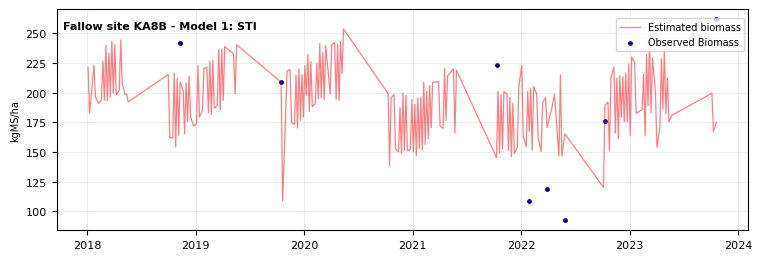

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,2.5), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.81, 0.81))
ax.set_title("Fallow site KA8B - Model 1: STI", fontsize = 8, fontweight = "bold", x = 0.15, y = .87)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_1_jachere.png", dpi = 600)

In [12]:
# Save the regression model
#joblib.dump(model_1, "./model 1/model_KA8B.pkl") 

#### 2. Model 2:  X = NDTI

In [13]:
# Define input output data
ndti_data = data_KA8B.iloc[:, [14, 19]]
ndti_data.head(2)

,NDTI,Biomasse (kg/ha)
0,0.078171,241.90
1,0.078277,208.75


In [14]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []

for i in range(0, len(ndti_data)):
    X = ndti_data[["NDTI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = ndti_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    
    X = ndti_data[["NDTI"]]
    y = ndti_data["Biomasse (kg/ha)"]
    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - (model_1.predict(X))))/y.values)
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]  

,coef,cste,R2,RMSE,mae,MAPE
1,[-2191.598875718514],381.421891,0.118605,57.356115,49.376849,0.333001


In [15]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[1]
model_1.intercept_ = reg_results.cste.values[1]

### Plot the results

In [16]:
# inputs
x_all = si_KA8B[["NDTI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


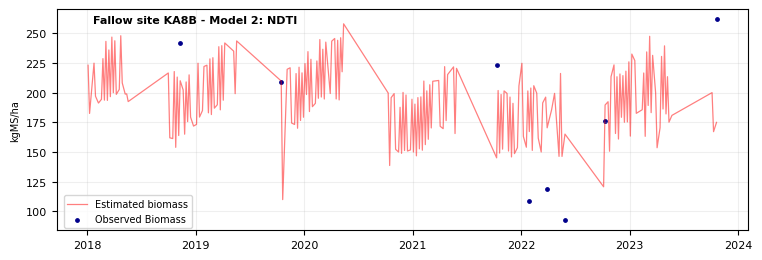

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,2.5), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.01, 0.01))
ax.set_title("Fallow site KA8B - Model 2: NDTI", fontsize = 8, fontweight = "bold", x = 0.2, y = .9)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_2_jachere.png", dpi = 600)

In [18]:
# Save the regression model
#joblib.dump(model_1, "./model 2/model_KA8B.pkl") 

#### 3. Model 3:  X = DFI

In [19]:
# Define input output data
dfi_data = data_KA8B.iloc[:, [15, 19]]
dfi_data.head(1)

,DFI,Biomasse (kg/ha)
0,11.405574,241.9


In [20]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []

for i in range(0, len(dfi_data)):
    X = dfi_data[["DFI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = dfi_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    
    X = dfi_data[["DFI"]]
    y = dfi_data["Biomasse (kg/ha)"]
    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - (model_1.predict(X))))/y.values)
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]

,coef,cste,R2,RMSE,mae,MAPE
1,[-19.82368618413399],448.408078,0.210756,54.27502,47.809221,0.30647


In [21]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[1]
model_1.intercept_ = reg_results.cste.values[1]

### Plot the results

In [22]:
# inputs
x_all = si_KA8B[["DFI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


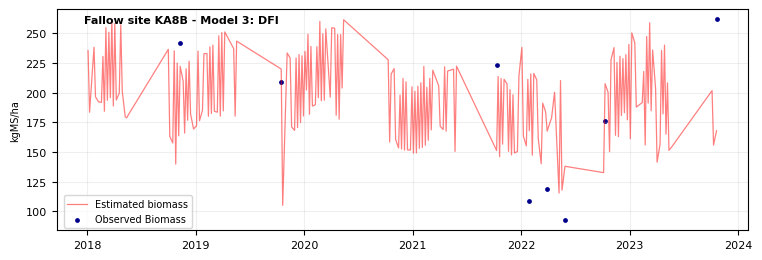

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,2.5), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.01, 0.01))
ax.set_title("Fallow site KA8B - Model 3: DFI", fontsize = 8, fontweight = "bold", x = 0.18, y = .9)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_3_jachere.png", dpi = 600)

In [24]:
# Save the regression model
#joblib.dump(model_1, "./model 3/model_KA8B.pkl") 

#### 4. Model 4:  X = NDRI

In [25]:
# Define input output data
ndri_data = data_KA8B.iloc[:, [16, 19]]
ndri_data.head(1)

,NDRI,Biomasse (kg/ha)
0,-0.170989,241.9


In [26]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []

for i in range(0, len(ndri_data)):
    X = ndri_data[["NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    
    X = ndri_data[["NDRI"]]
    y = ndri_data["Biomasse (kg/ha)"]
    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - (model_1.predict(X))))/y.values)
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]

,coef,cste,R2,RMSE,mae,MAPE
6,[-1536.0613791709955],-55.570416,0.32845,50.06491,45.504275,0.289165


In [27]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[6]
model_1.intercept_ = reg_results.cste.values[6]

### Plot the results

In [28]:
# inputs
x_all = si_KA8B[["NDRI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


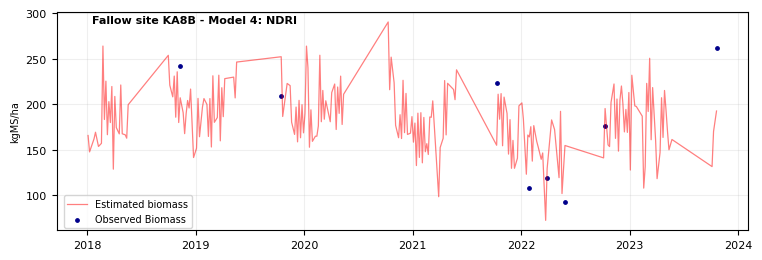

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,2.5), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.01, 0.01))
ax.set_title("Fallow site KA8B - Model 4: NDRI", fontsize = 8, fontweight = "bold", x = 0.2, y = .91)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_4_jachere.png", dpi = 600)

In [30]:
# Save the regression model
#joblib.dump(model_1, "./model 4/model_KA8B.pkl") 

#### 5. Model 5:  X = [STI, NDTI]

In [31]:
# Define input output data
sti_ndti_data = data_KA8B.iloc[:, [13,14,19]]
sti_ndti_data.head(1)

,STI,NDTI,Biomasse (kg/ha)
0,1.169599,0.078171,241.9


In [32]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []

for i in range(0, len(sti_ndti_data)):
    X = sti_ndti_data[["STI", "NDTI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_ndti_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    
    X = sti_ndti_data[["STI", "NDTI"]]
    y = sti_ndti_data["Biomasse (kg/ha)"]
        
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - (model_1.predict(X))))/y.values)
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]  

,coef,cste,R2,RMSE,mae,MAPE
6,"[115267.1126173352, -281351.38043089834]",-112591.995846,0.310919,50.714199,39.009565,0.252612


In [33]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[6]
model_1.intercept_ = reg_results.cste.values[6]

### Plot the results

In [34]:
# inputs
x_all = si_KA8B[["STI", "NDTI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


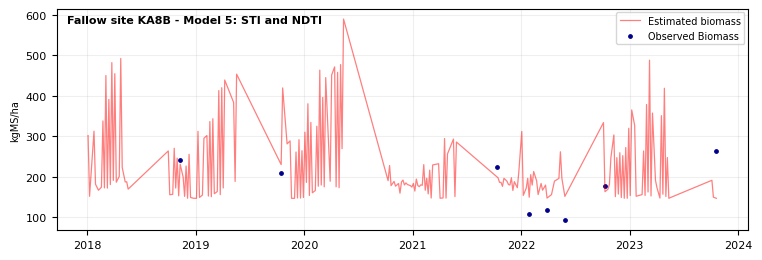

In [35]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,2.5), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.81, 0.84))
ax.set_title("Fallow site KA8B - Model 5: STI and NDTI", fontsize = 8, fontweight = "bold", x = 0.2, y = .9)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_5_jachere.png", dpi = 600)

In [36]:
# Save the regression model
#joblib.dump(model_1, "./model 5/model_KA8B.pkl") 

#### 6. Model 6:  X = [STI, DFI]

In [37]:
# Define input output data
sti_dfi_data = data_KA8B.iloc[:, [13,15,19]]
sti_dfi_data.head(1)

,STI,DFI,Biomasse (kg/ha)
0,1.169599,11.405574,241.9


In [38]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []
for i in range(0, len(sti_dfi_data)):
    X = sti_dfi_data[["STI", "DFI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_dfi_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    
    X = sti_dfi_data[["STI", "DFI"]]
    y = sti_dfi_data["Biomasse (kg/ha)"]
    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - (model_1.predict(X))))/y.values)
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]     

,coef,cste,R2,RMSE,mae,MAPE
1,"[1466.161780680091, -39.50979111965152]",-1051.686273,0.259817,52.561047,44.442261,0.27729


In [39]:
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[1]
model_1.intercept_ = reg_results.cste.values[1]

### Plot the results

In [40]:
# inputs
x_all = si_KA8B[["STI", "DFI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


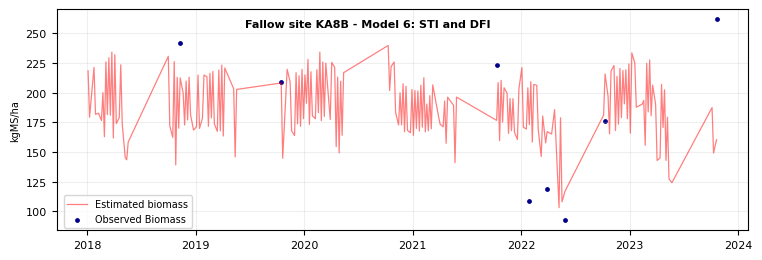

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,2.5), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.01, 0.01))
ax.set_title("Fallow site KA8B - Model 6: STI and DFI", fontsize = 8, fontweight = "bold", x = 0.45, y = .88)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_6_jachere.png", dpi = 600)

In [42]:
# Save the regression model
#joblib.dump(model_1, "./model 6/model_KA8B.pkl") 

#### 7. Model 7:  X = [STI, NDRI]

In [43]:
# Define input output data
sti_ndri_data = data_KA8B.iloc[:, [13,16,19]]
sti_ndri_data.head(1)

,STI,NDRI,Biomasse (kg/ha)
0,1.169599,-0.170989,241.9


In [44]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []

for i in range(0, len(sti_ndri_data)):
    X = sti_ndri_data[["STI", "NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = sti_ndri_data[["STI", "NDRI"]]
    y = sti_ndri_data["Biomasse (kg/ha)"]
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - (model_1.predict(X))))/y.values)
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]   

,coef,cste,R2,RMSE,mae,MAPE
6,"[952.8492512238204, -2303.1347119281904]",-1321.458931,0.378369,48.168251,43.721453,0.280692


In [45]:
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[6]
model_1.intercept_ = reg_results.cste.values[6]

### Plot the results

In [46]:
# inputs
x_all = si_KA8B[["STI", "NDRI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


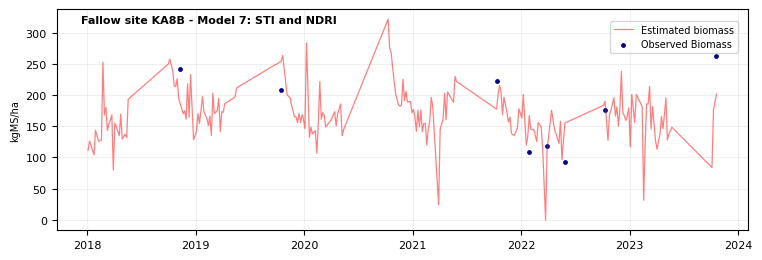

In [47]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,2.5), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.8, 0.8))
ax.set_title("Fallow site KA8B - Model 7: STI and NDRI", fontsize = 8, fontweight = "bold", x = 0.22, y = .9)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_7_jachere.png", dpi = 600)

In [48]:
# Save the regression model
#joblib.dump(model_1, "./model 7/model_KA8B.pkl") 

#### 8. Model 8:  X = [NDTI, DFI]

In [49]:
# Define input output data
ndti_dfi_data = data_KA8B.iloc[:, [14,15,19]]
ndti_dfi_data.head(1)

,NDTI,DFI,Biomasse (kg/ha)
0,0.078171,11.405574,241.9


In [50]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []

for i in range(0, len(ndti_dfi_data)):
    X = ndti_dfi_data[["NDTI", "DFI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = ndti_dfi_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    
    X = ndti_dfi_data[["NDTI", "DFI"]]
    y = ndti_dfi_data["Biomasse (kg/ha)"]
    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - (model_1.predict(X))))/y.values)
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]      

,coef,cste,R2,RMSE,mae,MAPE
1,"[3459.1081630542335, -38.9922083941474]",386.744073,0.256425,52.681339,44.69284,0.279129


In [51]:
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[1]
model_1.intercept_ = reg_results.cste.values[1]

### Plot the results

In [52]:
# inputs
x_all = si_KA8B[["NDTI", "DFI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


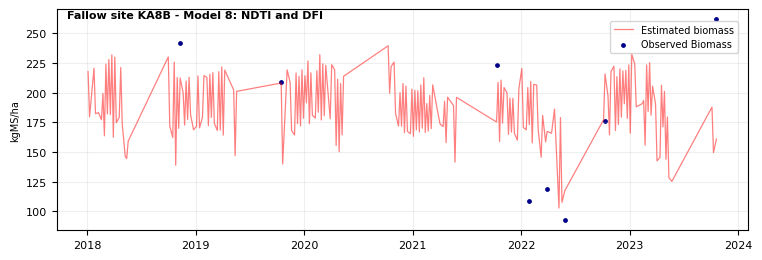

In [53]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,2.5), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.8, 0.8))
ax.set_title("Fallow site KA8B - Model 8: NDTI and DFI", fontsize = 8, fontweight = "bold", x = 0.2, y = .92)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_8_jachere.png", dpi = 600)

In [54]:
# Save the regression model
#joblib.dump(model_1, "./model 8/model_KA8B.pkl") 

#### 9. Model 9:  X = [NDTI, NDRI]

In [55]:
# Define input output data
ndti_ndri_data = data_KA8B.iloc[:, [14,16,19]]
ndti_ndri_data.head(1)

,NDTI,NDRI,Biomasse (kg/ha)
0,0.078171,-0.170989,241.9


In [56]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []

for i in range(0, len(ndti_ndri_data)):
    X = ndti_ndri_data[["NDTI", "NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = ndti_ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    
    X = ndti_ndri_data[["NDTI", "NDRI"]]
    y = ndti_ndri_data["Biomasse (kg/ha)"]
    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - (model_1.predict(X))))/y.values)
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]      

,coef,cste,R2,RMSE,mae,MAPE
6,"[2280.076618636083, -2296.5393378042913]",-383.981108,0.376504,48.240445,43.791823,0.28103


In [57]:
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[6]
model_1.intercept_ = reg_results.cste.values[6]

### Plot the results

In [58]:
# inputs
x_all = si_KA8B[["NDTI", "NDRI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


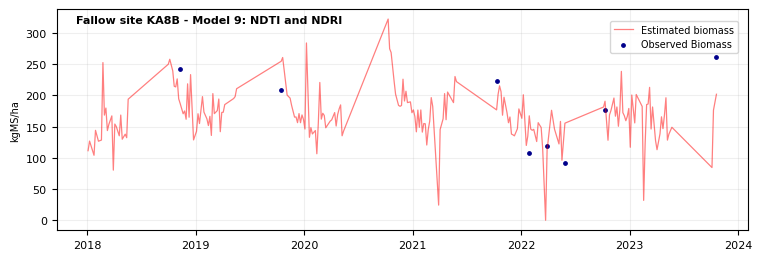

In [59]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,2.5), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.8, 0.8))
ax.set_title("Fallow site KA8B - Model 9: NDTI and NDRI", fontsize = 8, fontweight = "bold", x = 0.22, y = .9)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_9_jachere.png", dpi = 600)

In [60]:
# Save the regression model
#joblib.dump(model_1, "./model 9/model_KA8B.pkl") 

#### 10. Model 10:  X = [DFI, NDRI]

In [61]:
# Define input output data
dfi_ndri_data = data_KA8B.iloc[:, [15,16,19]]
dfi_ndri_data.head(1)

,DFI,NDRI,Biomasse (kg/ha)
0,11.405574,-0.170989,241.9


In [62]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []

for i in range(0, len(dfi_ndri_data)):
    X = dfi_ndri_data[["DFI", "NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = dfi_ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    
    X = dfi_ndri_data[["DFI", "NDRI"]]
    y = dfi_ndri_data["Biomasse (kg/ha)"]
    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - (model_1.predict(X))))/y.values)
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]  

,coef,cste,R2,RMSE,mae,MAPE
6,"[-3.308501028228155, -1372.9471454101795]",14.768218,0.325605,50.17085,45.877075,0.290293


In [63]:
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[6]
model_1.intercept_ = reg_results.cste.values[6]

### Plot the results

In [64]:
# inputs
x_all = si_KA8B[["DFI", "NDRI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


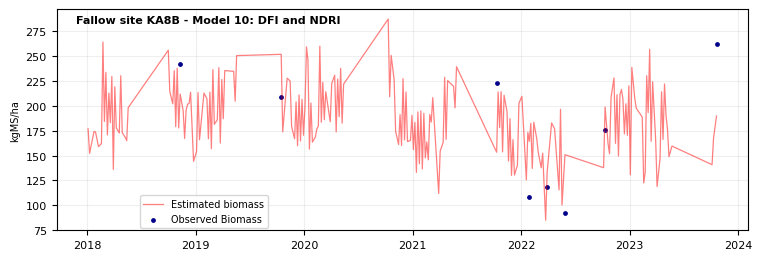

In [65]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,2.5), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.12, 0.01))
ax.set_title("Fallow site KA8B - Model 10: DFI and NDRI", fontsize = 8, fontweight = "bold", x = 0.22, y = .9)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_10_jachere.png", dpi = 600)

In [66]:
# Save the regression model
#joblib.dump(model_1, "./model 10/model_KA8B.pkl") 

#### 11. Model 11:  X = [STI, NDTI, DFI]

In [67]:
# Define input output data
sti_ndti_dfi_data = data_KA8B.iloc[:, [13, 14, 15,19]]
sti_ndti_dfi_data.head(1)

,STI,NDTI,DFI,Biomasse (kg/ha)
0,1.169599,0.078171,11.405574,241.9


In [68]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []

for i in range(0, len(sti_ndti_dfi_data)):
    X = sti_ndti_dfi_data[["STI", "NDTI", "DFI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_ndti_dfi_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    
    X = sti_ndti_dfi_data[["STI", "NDTI", "DFI"]]   
    y = sti_ndti_dfi_data["Biomasse (kg/ha)"]
        
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - (model_1.predict(X))))/y.values)
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]  

,coef,cste,R2,RMSE,mae,MAPE
0,"[75202.29866523285, -180174.02178187214, -25.9...",-73357.953385,0.350276,49.244618,36.470318,0.227746


In [69]:
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[0]
model_1.intercept_ = reg_results.cste.values[0]

### Plot the results

In [70]:
# inputs
x_all = si_KA8B[["STI", "NDTI", "DFI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


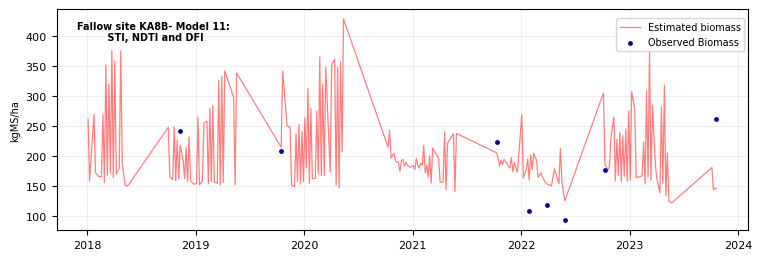

In [71]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,2.5), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.81, 0.81))
ax.set_title("Fallow site KA8B- Model 11:\n STI, NDTI and DFI", fontsize = 7, fontweight = "bold", x = 0.14, y = .82)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_11_jachere.png", dpi = 600)

In [72]:
# Save the regression model
#joblib.dump(model_1, "./model 11/model_KA8B.pkl") 

#### 12. Model 12:  X = [STI, NDTI, NDRI]

In [73]:
# Define input output data
sti_ndti_ndri_data = data_KA8B.iloc[:, [13, 14, 16,19]]
sti_ndti_ndri_data.head(1)

,STI,NDTI,NDRI,Biomasse (kg/ha)
0,1.169599,0.078171,-0.170989,241.9


In [74]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []

for i in range(0, len(sti_ndti_ndri_data)):
    X = sti_ndti_ndri_data[["STI","NDTI", "NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_ndti_ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    
    X = sti_ndti_ndri_data[["STI","NDTI", "NDRI"]]
    y = sti_ndti_ndri_data["Biomasse (kg/ha)"]
    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - (model_1.predict(X))))/y.values)
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]   

,coef,cste,R2,RMSE,mae,MAPE
6,"[70778.37922121437, -170120.76043391018, -1774...",-69583.415231,0.441989,45.636883,37.982362,0.240503


In [75]:
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[6]
model_1.intercept_ = reg_results.cste.values[6]

In [76]:
# Save the regression model
#joblib.dump(model_1, "./model 12/model_KA8B.pkl")

### Plot the results

In [77]:
# inputs
x_all = si_KA8B[["STI","NDTI", "NDRI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


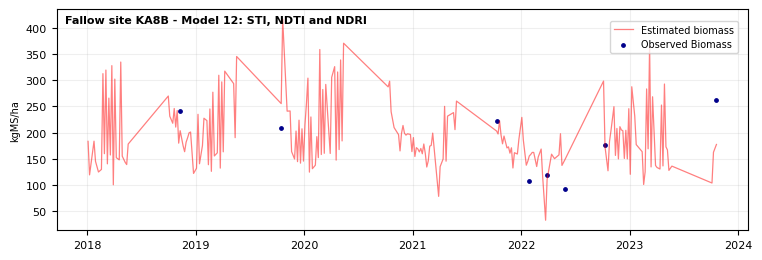

In [78]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,2.5), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.8, 0.8))
ax.set_title("Fallow site KA8B - Model 12: STI, NDTI and NDRI", fontsize = 8, fontweight = "bold", x = 0.23, y = .9)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_12_jachere.png", dpi = 600)

#### 13. Model 13:  X = [STI, DFI, NDRI]

In [79]:
# Define input output data
sti_dfi_ndri_data = data_KA8B.iloc[:, [13, 15, 16,19]]
sti_dfi_ndri_data.head(1)

,STI,DFI,NDRI,Biomasse (kg/ha)
0,1.169599,11.405574,-0.170989,241.9


In [80]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []

for i in range(0, len(sti_dfi_ndri_data)):
    X = sti_dfi_ndri_data[["STI","DFI", "NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_dfi_ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    
    X = sti_dfi_ndri_data[["STI","DFI", "NDRI"]]
    y = sti_dfi_ndri_data["Biomasse (kg/ha)"]
    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - (model_1.predict(X))))/y.values)
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]   

,coef,cste,R2,RMSE,mae,MAPE
4,"[2621.8636483626183, -29.003006288283117, -221...",-2927.87358,0.454705,45.113879,40.281169,0.238569


In [81]:
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[4]
model_1.intercept_ = reg_results.cste.values[4]

### Plot the results

In [82]:
# inputs
x_all = si_KA8B[["STI","DFI", "NDRI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


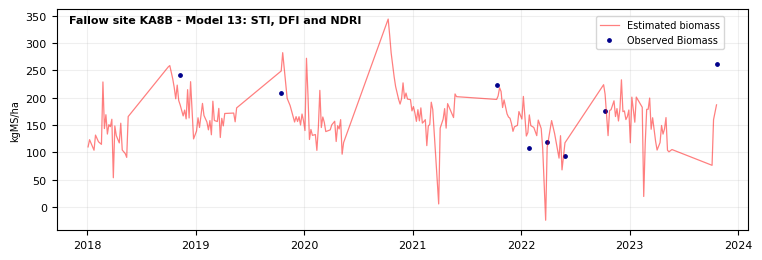

In [83]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,2.5), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.78, 0.82))
ax.set_title("Fallow site KA8B - Model 13: STI, DFI and NDRI", fontsize = 8, fontweight = "bold", x = 0.23, y = .9)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_13_jachere.png", dpi = 600)

In [84]:
# Save the regression model
#joblib.dump(model_1, "./model 13/model_KA8B.pkl") 

#### 14. Model 14:  X = [NDTI, DFI, NDRI]

In [85]:
# Define input output data
ndti_dfi_ndri_data = data_KA8B.iloc[:, [14, 15, 16,19]]
ndti_dfi_ndri_data.head(1)

,NDTI,DFI,NDRI,Biomasse (kg/ha)
0,0.078171,11.405574,-0.170989,241.9


In [86]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []

for i in range(0, len(ndti_dfi_ndri_data)):
    X = ndti_dfi_ndri_data[["NDTI","DFI", "NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = ndti_dfi_ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = ndti_dfi_ndri_data[["NDTI","DFI", "NDRI"]]
    y = ndti_dfi_ndri_data["Biomasse (kg/ha)"]
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - (model_1.predict(X))))/y.values)
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]  

,coef,cste,R2,RMSE,mae,MAPE
4,"[6354.9558451952635, -29.053686157060785, -221...",-358.096296,0.45204,45.223994,40.465241,0.239714


In [87]:
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[4]
model_1.intercept_ = reg_results.cste.values[4]

### Plot the results

In [88]:
# inputs
x_all = si_KA8B[["NDTI","DFI", "NDRI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


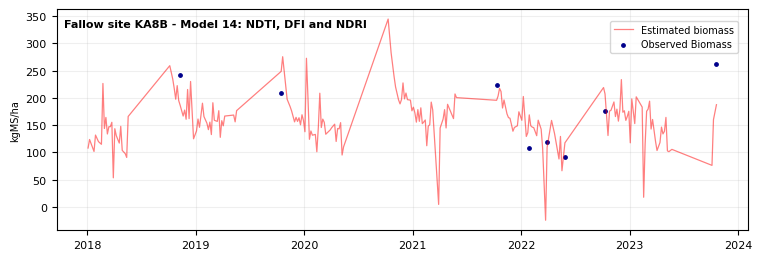

In [89]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,2.5), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.8, 0.8))
ax.set_title("Fallow site KA8B - Model 14: NDTI, DFI and NDRI", fontsize = 8, fontweight = "bold", x = 0.23, y = .88)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_14_jachere.png", dpi = 600)

In [90]:
# Save the regression model
#joblib.dump(model_1, "./model 14/model_KA8B.pkl") 

#### 15. Model 15:  X = [STI, NDTI, DFI, NDRI]

In [8]:
# Define input output data
sti_ndti_dfi_ndri_data = data_KA8B.iloc[:, [13, 14, 15, 16,19]]
sti_ndti_dfi_ndri_data.head(1)

,STI,NDTI,DFI,NDRI,Biomasse (kg/ha)
0,1.169599,0.078171,11.405574,-0.170989,241.9


In [9]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []
RMSPE_list = []


for i in range(0, len(sti_ndti_dfi_ndri_data)):
    X = sti_ndti_dfi_ndri_data[["STI","NDTI","DFI", "NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_ndti_dfi_ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = sti_ndti_dfi_ndri_data[["STI","NDTI","DFI", "NDRI"]]
    y = sti_ndti_dfi_ndri_data["Biomasse (kg/ha)"]   
   
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, model_1.predict(X), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  model_1.predict(X))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - model_1.predict(X)))/y.values)
    MAPE_list.append(mape)
    rmspe = rmspe = (np.sqrt(np.mean(np.square((y.values - model_1.predict(X)) / y.values)))) * 100
    RMSPE_list.append(rmspe)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list, "RMSPE": RMSPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]     

,coef,cste,R2,RMSE,mae,MAPE,RMSPE
4,"[49666.82958820836, -115516.04538513823, -22.2...",-48939.50641,0.479856,44.061208,37.005694,0.220655,26.00911


In [10]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[4]
model_1.intercept_ = reg_results.cste.values[4]

### Plot the results

In [94]:
# inputs
x_all = si_KA8B[["STI","NDTI","DFI", "NDRI"]]
y_all = model_1.predict(x_all)
#y_all

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


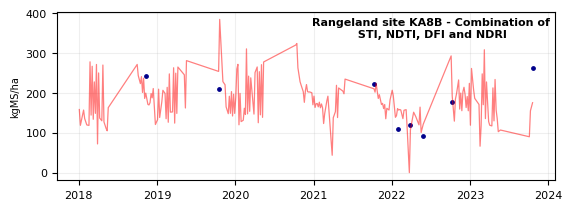

In [97]:
fig, ax = plt.subplots(1, 1, figsize = (5.6,2.), constrained_layout = True)
ax.scatter(obs_mass.index, obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(si_KA8B.date, y_all, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
#ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
#ax.legend(fontsize = 7, loc = (0.01, 0.81))
ax.set_title("Rangeland site KA8B - Combination of\n STI, NDTI, DFI and NDRI", fontsize = 8, fontweight = "bold", x = 0.75, y = .8)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/KA8B/model_15_jachere.png", dpi = 600)

In [96]:
# Save the regression model
#import joblib
## save
#joblib.dump(model_1, "./model 15/model_KA8B.pkl") 